In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import skimage as ski
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from sklearn.model_selection import KFold, permutation_test_score
from sklearn.decomposition import PCA
from skimage import transform as ski_transform
from torchvision.transforms import ToTensor, Normalize, Compose, RandomRotation
from torchvision import models
import cv2
import joblib
import seaborn as sns

In [15]:
FOLD = 4
NUM_FOLDS = 5
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
IMAGE_SIZE = 256
NUM_CLASSES = 2
RESIZE = (256,256)

In [16]:
train_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images'
test_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/test/images'

train_path_csv = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/train.csv'
test_path_csv = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/test.csv'

train_image_list = glob(os.path.join(train_path ,'*.png'))
train_image_list.sort()

test_image_list = glob(os.path.join(test_path, '*.png'))
test_image_list.sort()


In [17]:
train_data_df = pd.read_csv(train_path_csv)

# sort the dataframe by image name
train_data_df = train_data_df.sort_values(by='id')
train_data_df = train_data_df.reset_index(drop=True)


test_data_df = pd.read_csv(test_path_csv)
# sort the dataframe by image name
test_data_df = test_data_df.sort_values(by='id')
test_data_df = test_data_df.reset_index(drop=True)

In [18]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, is_train= True, resize_dim = (224, 224)):
        self.resize_dim = resize_dim
        self.images = images
        self.is_train = is_train
        if is_train:
            self.labels = labels
        else:
            self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx >= len(self.images):
            print('Reduce the index count as it is greater than the length of the dataset')
            return None
        if idx < 0:
            print('Index should be greater than or equal to 0')
            return None
        data = {}

        if self.is_train:
            data['image'] = Image.open(self.images[idx])
            data['class_label'] = self.labels.iloc[idx, 1]
            data['id'] = self.labels.iloc[idx, 0]
            data['image'] = data['image'].resize(self.resize_dim)
            data['class_label'] = torch.tensor(data['class_label']).float()
            return data
        else:
            data['image'] = Image.open(self.images[idx])
            data['id'] = self.labels.iloc[idx, 0]
            return data



In [ ]:
from sklearn.svm import SVC
# Split the images in val and train from train_path
def create_k_fold_split(train_img_list, train_csv_path):
    # Create a KFold object

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_img_paths = train_image_list
    train_img_paths.sort()
    train_labels = pd.read_csv(train_csv_path)
    train_labels = train_labels.sort_values(by='id')
    train_labels.index = range(len(train_labels))
    print(train_img_paths)
    split = list(kf.split(train_img_paths))
    return split, train_img_paths, train_labels

split, train_img_paths, train_labels = create_k_fold_split(train_image_list, train_path_csv)
from sklearn.svm import SVC
kernel = 'poly'
svc = SVC(kernel=kernel,gamma='auto')
metrics ={}

for repeat in range(3):
    for fold in range(NUM_FOLDS):
            metrics = {}
            train_indices, val_indices = split[fold]
            train_data = []
            val_data = []
            for i in train_indices:
                image = train_img_paths[i]
                image_array = cv2.imread(image)
                image_array = cv2.resize(image_array, RESIZE)
                label = train_labels.iloc[i, 1]
                train_data.append((image_array, label))

            for i in val_indices:
                image = train_img_paths[i]
                image_array = cv2.imread(image)
                image_array = cv2.resize(image_array, RESIZE)
                label = train_labels.iloc[i, 1]
                val_data.append((image_array, label))

            X_train = []
            Y_train = []
            X_val = []
            Y_val = []

            for sample, label in train_data:
                X_train.append(sample)
                Y_train.append(label)

            for sample, label in val_data:
                X_val.append(sample)
                Y_val.append(label)

            pca = PCA(n_components=0.95)
            X_train = np.array(X_train).reshape(len(train_data), -1)
            X_train_pca = pca.fit_transform(X_train)
            
            # Save the fitted PCA model for this fold
            joblib.dump(pca, f'classification_svm/pca_model_fold_{fold}_repeat_{repeat+1}.joblib')
        
            Y_train = np.array(Y_train)

            X_val = np.array(X_val).reshape(len(val_data), -1)
            X_val_pca = pca.transform(X_val)
            Y_val = np.array(Y_val)

            X_train_pca = X_train_pca/255
            X_val_pca = X_val_pca/255
            print(f'X_train_pca shape: {X_train_pca.shape}')
            print(f'X_val_pca shape: {X_val_pca.shape}')

            svc.fit(X_train_pca, Y_train)
            # Save the SVM model

            joblib.dump(svc, f'classification_svm/{kernel}_svm_model_fold_{fold}.pkl')
            y_pred = svc.predict(X_val_pca)
            count_1 = (y_pred == 1).sum()
            count_0 = (y_pred == 0).sum()
            print('Predicted 1:', count_1)
            print('Predicted 0:', count_0)
            tp = ((y_pred == 1) & (Y_val == 1)).sum()
            tn = ((y_pred == 0) & (Y_val == 0)).sum()
            fp = ((y_pred == 1) & (Y_val == 0)).sum()
            fn = ((y_pred == 0) & (Y_val == 1)).sum()
            print('True Positive:', tp)
            print('True Negative:', tn)
            print('False Positive:', fp)
            print('False Negative:', fn)
            from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
            print('Accuracy:', accuracy_score(Y_val, y_pred))
            print('F1 Score:', f1_score(Y_val, y_pred))
            print('Precision:', precision_score(Y_val, y_pred))
            print('Recall:', recall_score(Y_val, y_pred))
            metrics[fold] = {
                'accuracy': accuracy_score(Y_val, y_pred),
                'f1_score': f1_score(Y_val, y_pred),
                'precision': precision_score(Y_val, y_pred),
                'recall': recall_score(Y_val, y_pred),
                'fold': fold,
                'repeat': repeat + 1
            }
            # Save the metrics to csv
            metrics_df = pd.DataFrame(metrics).T
            metrics_df.to_csv(f'classification_svm/metrics_{fold}_repeat_{repeat+1}.csv', index=False)


['/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/0.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/1.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/10.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/100.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/101.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/102.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/103.png', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/mlds_assignmet_2_ml_dl/Dataset/train/images/104.png', '/home/biomedialab/Desktop/Codes/Assignments

In [34]:
# Decide the class of the test images based on voting from the 5 folds
# Load the SVM model
model_path = f'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm'
model_list = glob(os.path.join(model_path, 'poly_svm_model_fold_*_repeat_1.pkl'))
model_list.sort()
print('Model list:', model_list)
test_data = []
for i in range(len(test_image_list)):
    image = test_image_list[i]
    image_array = cv2.imread(image)
    image_array = cv2.resize(image_array, RESIZE)
    test_data.append((image_array, i))
X_test = []
for sample, label in test_data:
    X_test.append(sample)
X_test = np.array(X_test).reshape(len(test_data), -1)
# Load the PCA model used during training

y_pred = []
for model in model_list:
    # Load the SVM model
    print('Model:', model)
    pca_model_name = model.replace('poly_svm_model', 'pca_model')
    pca_model_name = pca_model_name.replace('.pkl', '.joblib')
    pca = joblib.load(pca_model_name)
    X_test_pca = pca.transform(X_test)
    X_test_pca = X_test_pca/255
    # print(f'X_test_pca shape: {X_test_pca.shape}')
    svc = joblib.load(model)
    y_pred_fold = svc.predict(X_test_pca)
    y_pred.append(y_pred_fold)

y_pred = np.array(y_pred)
print('y_pred shape:', y_pred.shape)
# Decide the class based on voting
y_pred_final = []
for i in range(y_pred.shape[1]):
    count_1 = (y_pred[:, i] == 1).sum()
    count_0 = (y_pred[:, i] == 0).sum()
    if count_1 > count_0:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)
y_pred_final = np.array(y_pred_final)


# Save the predictions in a csv file
test_data_df['binary_pred'] = y_pred_final
test_data_df.drop(columns=['segmentation_pred'], inplace=True)
test_data_df.to_csv('submission_svm.csv', index=False)
print('Submission file created successfully')

Model list: ['/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_0_repeat_1.pkl', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_1_repeat_1.pkl', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_2_repeat_1.pkl', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_3_repeat_1.pkl', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_4_repeat_1.pkl']
Model: /home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_0_repeat_1.pkl
Model: /home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_1_repeat_1.pkl
Model: /home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/poly_svm_model_fold_2_repeat_1.pkl

# The following code performs hypothesis testing based on the output of cnn model and SVM model

SVM file list: ['/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_0_repeat_1.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_0_repeat_2.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_0_repeat_3.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_1_repeat_1.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_1_repeat_2.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_1_repeat_3.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_2_repeat_1.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_2_repeat_2.csv', '/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm/metrics_2_repeat_3.

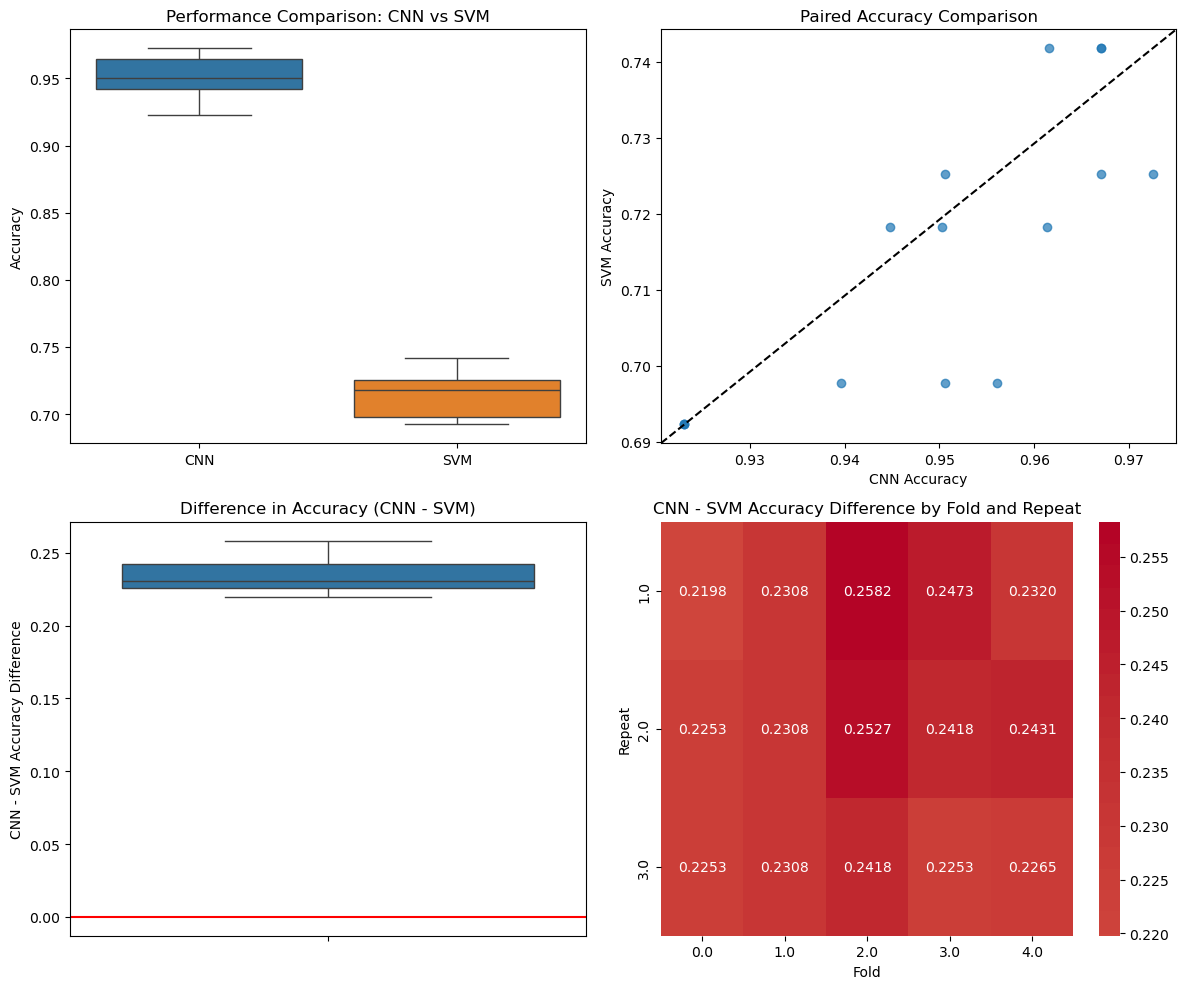


Shapiro-Wilk test on differences: p-value = 0.1952
The differences appear normally distributed. Using paired t-test.

Paired t-test Results:
t = 80.2070
p-value: 0.0000
Reject the null hypothesis (p < 0.05)
There is a statistically significant difference between CNN and SVM performance.
The CNN model performed significantly better.
Mean CNN accuracy: 0.9505
Mean SVM accuracy: 0.7151
Mean difference: 0.2354 in favor of CNN

Effect size (Cohen's d): 20.7094
This represents a large effect size.

95% Confidence Interval for mean difference: [0.2291, 0.2417]


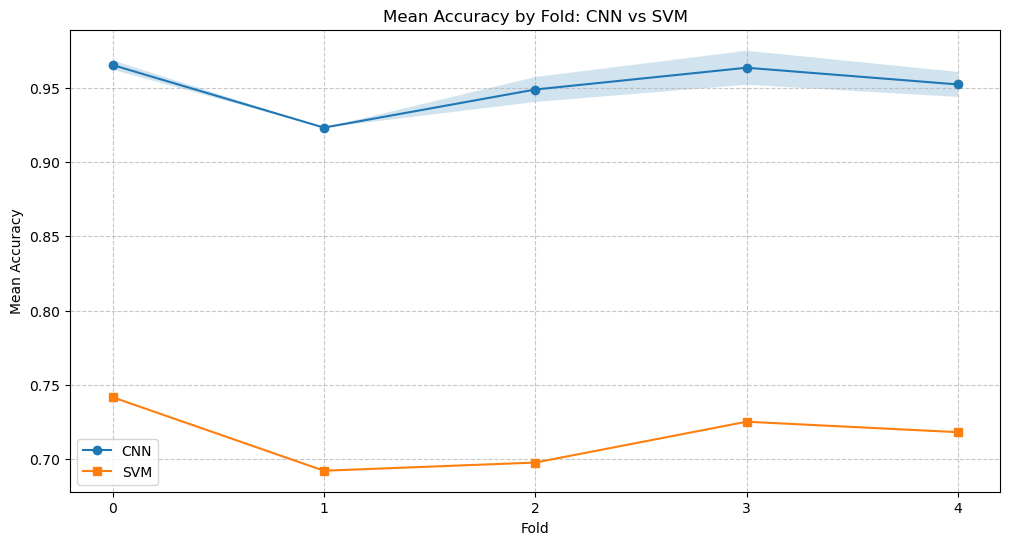


Hypothesis testing complete!


In [35]:

from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Get accuracy results from CSV files to perform hypothesis testing between two models
# Paths to the model results
svm_scores_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_svm'
cnn_accuracy_path = r'/home/biomedialab/Desktop/Codes/Assignments/MLDS/Assignment_2/Q2/classification_model'

# Get SVM results
file_list = glob(os.path.join(svm_scores_path, 'metrics_*.csv'))
file_list.sort()
print('SVM file list:', file_list)

# Read the SVM csv files and get the accuracy scores
svm_accuracy_scores = []
for file in file_list:
    df = pd.read_csv(file)
    tup = (df['repeat'].values[0], df['fold'].values[0], df['accuracy'].values[0])
    svm_accuracy_scores.append(tup)

# Get CNN results
cnn_file_list = glob(os.path.join(cnn_accuracy_path, 'class_results_resnet18_*.csv'))
cnn_file_list.sort()
print('CNN file list:', cnn_file_list)

# Read the CNN csv files and get the accuracy scores
cnn_accuracy_scores = []
for file in cnn_file_list:
    df = pd.read_csv(file)
    # Parse filename to get fold and repeat
    parts = file.split('_')
    fold = int(parts[-3])
    repeat = int(parts[-1].split('.')[0])  # Remove file extension
    
    # Get accuracy score related to min val loss
    min_val_loss = df['val_loss'].min()
    min_val_loss_index = df[df['val_loss'] == min_val_loss].index[0]
    accuracy = df['val_accuracy'].values[min_val_loss_index]
    
    tup = (repeat, fold, accuracy)
    cnn_accuracy_scores.append(tup)

print(f"Found {len(svm_accuracy_scores)} SVM results and {len(cnn_accuracy_scores)} CNN results")

# Create DataFrames from the collected results
svm_df = pd.DataFrame(svm_accuracy_scores, columns=['repeat', 'fold', 'accuracy'])
cnn_df = pd.DataFrame(cnn_accuracy_scores, columns=['repeat', 'fold', 'accuracy'])

# Ensure both DataFrames have the same index for proper pairing
svm_df.set_index(['repeat', 'fold'], inplace=True)
cnn_df.set_index(['repeat', 'fold'], inplace=True)

# Find common fold-repeat combinations
common_indices = set(svm_df.index).intersection(set(cnn_df.index))
print(f"Number of matching fold-repeat combinations: {len(common_indices)}")

if len(common_indices) == 0:
    raise ValueError("No matching fold-repeat combinations found between CNN and SVM results")

# Filter both DataFrames to include only common indices
svm_filtered = svm_df.loc[list(common_indices)]
cnn_filtered = cnn_df.loc[list(common_indices)]

# Sort both DataFrames by index to ensure alignment
svm_filtered = svm_filtered.sort_index()
cnn_filtered = cnn_filtered.sort_index()

# Extract accuracy values as numpy arrays
svm_accuracy = svm_filtered['accuracy'].values
cnn_accuracy = cnn_filtered['accuracy'].values

# Verify that the arrays have the same length
assert len(svm_accuracy) == len(cnn_accuracy), "Array lengths don't match!"

# Print the paired data
paired_data = pd.DataFrame({
    'fold': [idx[1] for idx in svm_filtered.index],
    'repeat': [idx[0] for idx in svm_filtered.index],
    'svm_accuracy': svm_accuracy,
    'cnn_accuracy': cnn_accuracy,
    'difference': cnn_accuracy - svm_accuracy
})
print("\nPaired accuracy data:")
print(paired_data)

# Step 1: Visualize the data
plt.figure(figsize=(12, 10))

# Subplot 1: Boxplot comparison
plt.subplot(2, 2, 1)
data_to_plot = [cnn_accuracy, svm_accuracy]
sns.boxplot(data=data_to_plot)
plt.xticks([0, 1], ['CNN', 'SVM'])
plt.ylabel('Accuracy')
plt.title('Performance Comparison: CNN vs SVM')

# Subplot 2: Paired scatter plot
plt.subplot(2, 2, 2)
plt.scatter(cnn_accuracy, svm_accuracy, alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', transform=plt.gca().transAxes)  # Diagonal line
plt.xlabel('CNN Accuracy')
plt.ylabel('SVM Accuracy')
plt.title('Paired Accuracy Comparison')

# Subplot 3: Boxplot of differences
plt.subplot(2, 2, 3)
diff = cnn_accuracy - svm_accuracy
sns.boxplot(y=diff)
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel('CNN - SVM Accuracy Difference')
plt.title('Difference in Accuracy (CNN - SVM)')

# Subplot 4: Heatmap of differences by fold and repeat
plt.subplot(2, 2, 4)
pivot_diff = paired_data.pivot(index='repeat', columns='fold', values='difference')
sns.heatmap(pivot_diff, annot=True, cmap='coolwarm', center=0, fmt='.4f')
plt.title('CNN - SVM Accuracy Difference by Fold and Repeat')
plt.ylabel('Repeat')
plt.xlabel('Fold')

plt.tight_layout()
plt.savefig('model_comparison_visualization.png')
plt.show()

# Step 2: Check normality of the differences
_, p_value_norm = shapiro(diff)
print(f"\nShapiro-Wilk test on differences: p-value = {p_value_norm:.4f}")

# Determine which test to use
alpha = 0.05
if p_value_norm > alpha:
    print("The differences appear normally distributed. Using paired t-test.")
    # Paired t-test
    t_stat, p_value = ttest_rel(cnn_accuracy, svm_accuracy)
    test_name = "Paired t-test"
    test_stat = f"t = {t_stat:.4f}"
else:
    print("The differences don't appear normally distributed. Using Wilcoxon signed-rank test.")
    # Wilcoxon signed-rank test
    w_stat, p_value = wilcoxon(cnn_accuracy, svm_accuracy)
    test_name = "Wilcoxon signed-rank test"
    test_stat = f"W = {w_stat:.4f}"

# Step 3: Perform the appropriate hypothesis test and interpret results
print(f"\n{test_name} Results:")
print(test_stat)
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print(f"Reject the null hypothesis (p < {alpha})")
    print("There is a statistically significant difference between CNN and SVM performance.")
    
    # Determine which model performed better
    mean_diff = np.mean(diff)
    better_model = "CNN" if mean_diff > 0 else "SVM"
    print(f"The {better_model} model performed significantly better.")
    print(f"Mean CNN accuracy: {np.mean(cnn_accuracy):.4f}")
    print(f"Mean SVM accuracy: {np.mean(svm_accuracy):.4f}")
    print(f"Mean difference: {abs(mean_diff):.4f} in favor of {better_model}")
else:
    print(f"Fail to reject the null hypothesis (p >= {alpha})")
    print("There is no statistically significant difference between CNN and SVM performance.")
    print(f"Mean CNN accuracy: {np.mean(cnn_accuracy):.4f}")
    print(f"Mean SVM accuracy: {np.mean(svm_accuracy):.4f}")
    print(f"Mean difference: {abs(np.mean(diff)):.4f}")

# Step 4: Calculate effect size
# Cohen's d for paired data
d = mean_diff / np.std(diff, ddof=1)
print(f"\nEffect size (Cohen's d): {abs(d):.4f}")

# Interpret effect size
if abs(d) < 0.2:
    effect = "negligible"
elif abs(d) < 0.5:
    effect = "small"
elif abs(d) < 0.8:
    effect = "medium"
else:
    effect = "large"

print(f"This represents a {effect} effect size.")

# Step 5: Create a confidence interval for the difference
if p_value_norm > alpha:  # Only if normality assumption is met
    ci = stats.t.interval(0.95, len(diff)-1, 
                         loc=mean_diff, 
                         scale=stats.sem(diff))
    print(f"\n95% Confidence Interval for mean difference: [{ci[0]:.4f}, {ci[1]:.4f}]")

# Additional visualization: Performance across folds
plt.figure(figsize=(12, 6))
fold_means = paired_data.groupby('fold')[['cnn_accuracy', 'svm_accuracy']].mean()

plt.plot(fold_means.index, fold_means['cnn_accuracy'], 'o-', label='CNN')
plt.plot(fold_means.index, fold_means['svm_accuracy'], 's-', label='SVM')
plt.fill_between(fold_means.index, 
                fold_means['cnn_accuracy'] - paired_data.groupby('fold')['cnn_accuracy'].std(),
                fold_means['cnn_accuracy'] + paired_data.groupby('fold')['cnn_accuracy'].std(), 
                alpha=0.2)
plt.fill_between(fold_means.index, 
                fold_means['svm_accuracy'] - paired_data.groupby('fold')['svm_accuracy'].std(),
                fold_means['svm_accuracy'] + paired_data.groupby('fold')['svm_accuracy'].std(), 
                alpha=0.2)

plt.xlabel('Fold')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy by Fold: CNN vs SVM')
plt.xticks(fold_means.index)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('fold_comparison_line.png')
plt.show()

print("\nHypothesis testing complete!")
